## Downloading the dataset and performing data preprocessing

In [1]:
!wget2 -q --no-clobber https://raw.githubusercontent.com/SoumadipDey/datasets/refs/heads/main/UCI_Credit_Card.csv

In [2]:
!pip install torchsummary -q

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import warnings
warnings.filterwarnings("ignore")

**Loading the dataset into a pandas DataFrame**

In [4]:
df = pd.read_csv("UCI_Credit_Card.csv")
df.drop(['ID'], axis=1, inplace=True)
df.rename(columns={"default.payment.next.month": "Defaulter"}, inplace=True)
print(df.shape)
df.head()

(30000, 24)


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Defaulter
0,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


**Checking for NAN values and Imputing if needed**

In [5]:
df.isna().sum()

LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
Defaulter    0
dtype: int64

**Seperating the Features and the Target**

In [6]:
X_df = df.drop(['Defaulter'], axis = 1)
y = df['Defaulter']

**Converting Categorical Features into Numerical Features** 

In [7]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

numerical_features = X_df.select_dtypes(include=np.number).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
    ])

X_df_processed = preprocessor.fit_transform(X_df)

In [8]:
print(X_df_processed.shape)
num_features = X_df_processed.shape[1]

(30000, 23)


**Splitting into a Training and Validation Dataset**

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_df_processed, y, test_size=0.3, 
                                                    random_state=42, stratify=y)
print("Dimensions: ")
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

Dimensions: 
(21000, 23) (9000, 23)
(21000,) (9000,)


**Converting Train and Test Sets to Pytorch Tensors**

In [10]:
X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)
y_train_tensor = torch.FloatTensor(y_train.values).view(-1, 1)
y_test_tensor = torch.FloatTensor(y_test.values).view(-1, 1)

## Defining the model architecture and training the model

In [11]:
from torchsummary import summary

class MLPClassifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        
        self.layer1 = nn.Linear(input_dim, 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, 64)
        self.layer4 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        # Dropout layer to prevent overfitting
        self.dropout = nn.Dropout(p=0.25)

    def forward(self, x):
        
        x = self.relu(self.layer1(x))
        x = self.dropout(x)
        x = self.relu(self.layer2(x))
        x = self.dropout(x)
        x = self.relu(self.layer3(x))
        x = self.dropout(x)
        x = self.relu(self.layer4(x))
        x = self.output(x)
        return x

model = MLPClassifier(input_dim = num_features)
summary(model, input_size=(1, num_features))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]           6,144
              ReLU-2               [-1, 1, 256]               0
           Dropout-3               [-1, 1, 256]               0
            Linear-4               [-1, 1, 128]          32,896
              ReLU-5               [-1, 1, 128]               0
           Dropout-6               [-1, 1, 128]               0
            Linear-7                [-1, 1, 64]           8,256
              ReLU-8                [-1, 1, 64]               0
           Dropout-9                [-1, 1, 64]               0
           Linear-10                [-1, 1, 32]           2,080
             ReLU-11                [-1, 1, 32]               0
           Linear-12                 [-1, 1, 1]              33
Total params: 49,409
Trainable params: 49,409
Non-trainable params: 0
---------------------------------

**Defining Loss function and Optimizer**

In [12]:
loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

**Training and Validation Loop (Note: The test set is used as the validation set in this experiment)**

In [13]:
history = {"Train Loss": [],"Train Acc": [], "Test Loss": [],"Test Acc": []}
num_epochs = 200

print("Training the model: ")
for epoch in range(num_epochs):
    ## Training Section
    model.train()
    optimizer.zero_grad()

    logits = model(X_train_tensor)
    running_loss = loss_function(logits, y_train_tensor)

    running_loss.backward()
    optimizer.step()

    preds = (torch.sigmoid(logits) > 0.5).float()
    correct_pred = (preds == y_train_tensor).sum().item()
    acc = correct_pred / preds.size(0)

    history["Train Loss"].append(running_loss.item())
    history["Train Acc"].append(acc)

    ## Validation Section
    model.eval()
    with torch.no_grad():
        logits = model(X_test_tensor)
        test_running_loss = loss_function(logits, y_test_tensor)
    
        preds = (torch.sigmoid(logits) > 0.5).float()
        correct_pred = (preds == y_test_tensor).sum().item()
        test_acc = correct_pred / preds.size(0)
    
        history["Test Loss"].append(test_running_loss.item())
        history["Test Acc"].append(test_acc)
    
    if((epoch+1)%10 == 0):
        print(f"\nEpoch {epoch+1}")
        print(f"Train Loss: {running_loss.item():.4f} || Train Acc: {acc:.4f}")
        print(f"Test Loss: {test_running_loss.item():.4f} || Test Acc: {test_acc:.4f}")

Training the model: 

Epoch 10
Train Loss: 0.6141 || Train Acc: 0.7788
Test Loss: 0.5991 || Test Acc: 0.7788

Epoch 20
Train Loss: 0.5451 || Train Acc: 0.7788
Test Loss: 0.5445 || Test Acc: 0.7788

Epoch 30
Train Loss: 0.5142 || Train Acc: 0.7788
Test Loss: 0.5149 || Test Acc: 0.7788

Epoch 40
Train Loss: 0.4953 || Train Acc: 0.7804
Test Loss: 0.4973 || Test Acc: 0.7804

Epoch 50
Train Loss: 0.4796 || Train Acc: 0.7997
Test Loss: 0.4790 || Test Acc: 0.8016

Epoch 60
Train Loss: 0.4646 || Train Acc: 0.8122
Test Loss: 0.4633 || Test Acc: 0.8098

Epoch 70
Train Loss: 0.4547 || Train Acc: 0.8175
Test Loss: 0.4524 || Test Acc: 0.8127

Epoch 80
Train Loss: 0.4514 || Train Acc: 0.8144
Test Loss: 0.4473 || Test Acc: 0.8126

Epoch 90
Train Loss: 0.4458 || Train Acc: 0.8170
Test Loss: 0.4439 || Test Acc: 0.8132

Epoch 100
Train Loss: 0.4428 || Train Acc: 0.8166
Test Loss: 0.4406 || Test Acc: 0.8143

Epoch 110
Train Loss: 0.4378 || Train Acc: 0.8201
Test Loss: 0.4383 || Test Acc: 0.8150

Epoch 12

**Plotting the Training Curve**

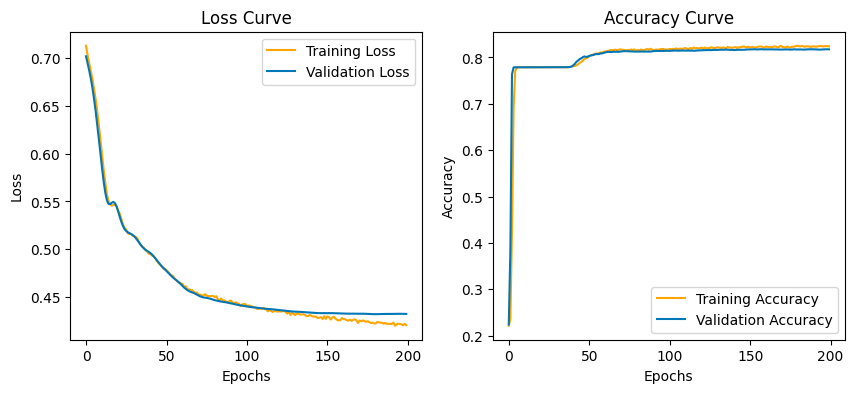

In [14]:
fig, ax = plt.subplots(1, 2 , figsize = (10,4))
plt.sca(ax[0])
plt.plot(history["Train Loss"], color = 'orange', label = "Training Loss")
plt.plot(history["Test Loss"], color = '#0077b6', label = "Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.sca(ax[1])
plt.plot(history["Train Acc"], color = 'orange', label = "Training Accuracy")
plt.plot(history["Test Acc"], color = '#0077b6', label = "Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()
plt.show()

## Checking the Performance of the Trained Model on the Test Dataset 

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
def modelPredictions(model, dataset, enable_proba = False):
    with torch.no_grad():
        model.eval()
        logits = model(dataset)
        preds_proba = torch.sigmoid(logits)
        preds = (torch.sigmoid(logits) > 0.5).float()
    
    if not enable_proba:
        return preds.numpy()
    else: 
        return preds.numpy(), preds_proba.numpy()

y_pred = modelPredictions(model, X_test_tensor)
print(classification_report(y_test.values.squeeze(), y_pred))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      7009
           1       0.66      0.37      0.47      1991

    accuracy                           0.82      9000
   macro avg       0.75      0.66      0.68      9000
weighted avg       0.80      0.82      0.80      9000



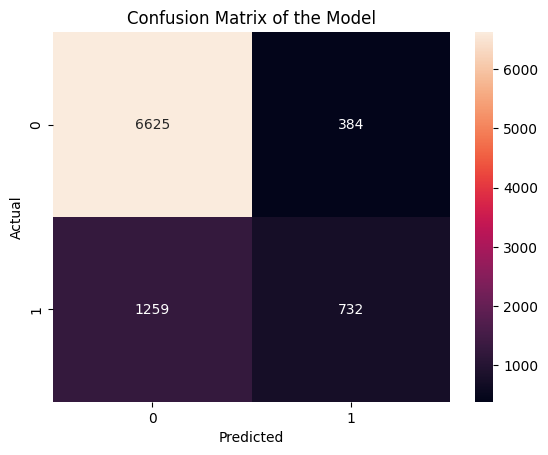

In [17]:
plt.title("Confusion Matrix of the Model")
sns.heatmap(confusion_matrix(y_test.values.squeeze(), y_pred), annot=True, fmt="d")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()